<div style="background-color:gray; padding:15px; border-radius:10px; font-size:20px; color:white;">
    <h2 style="margin-bottom:10px;">스태킹 앙상블 목차</h2>
    <ol style="padding-left:20px;">
        <li>(시도 1) 메타모델을 XGB 모델로 학습</li>
        <li>(시도 2) 메타모델을 릿지 회귀모형으로 학습</li>
        <li>(시도 3) 메타모델을 릿지 회귀모형으로 학습 (다른 알파값)</li>
    </ol>
</div>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import root_mean_squared_error


In [41]:
te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')
y_df = pd.read_csv('y_df')
sub = pd.read_csv('sample_submission.csv')

In [4]:
te_train_df.head()

,Brand_TE,Material_TE,Size_TE,Compartments_TE,Laptop Compartment_TE,Waterproof_TE,Style_TE,Color_TE,Weight Capacity (kg)_TE,Missing_count
0,81.766600,80.482808,81.197151,81.608400,81.418773,81.431367,81.498538,80.319375,82.699785,0
1,81.777256,81.831401,81.471377,81.548357,81.425348,81.413824,81.189047,82.238982,81.365737,0
2,82.068264,80.489584,81.460863,81.615232,81.417223,81.437409,81.188867,81.008732,81.360793,0
3,81.286106,81.059274,81.461402,81.724961,81.418773,81.431367,81.188657,82.235106,81.356545,0
4,80.528193,81.827587,81.203076,81.037864,81.433576,81.422242,81.194270,82.264042,81.369522,0


In [ ]:

# ------------------------------------------------------------- Xgb 모델 OOF 값 생성 --------------------------------------------------

# XGBoost 최적 하이퍼파라미터
xgb_params = {
    'learning_rate': 0.013703799543482834,
    'max_depth': 6,
    'subsample': 0.9146994136721976,
    'min_child_weight': 4,
    'colsample_bytree': 0.873195834229002,
    'gamma': 1.4319945252821071,
    'reg_alpha': 5.208058683903292,
    'reg_lambda': 9.29985066405108,
    "tree_method": "hist",
    "device": "cuda",
    "objective": "reg:squarederror"
}

num_boost_round = 573  

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state= 1)

# OOF Predictions 저장 공간 (훈련 데이터 크기만큼)
xgb_oof_series = pd.Series(np.zeros(te_train_df.shape[0]), index=te_train_df.index)

# 테스트 데이터 예측값 저장 (K-Fold 평균)
xgb_test_preds = np.zeros(te_test_df.shape[0])

for fold, (train_idx, val_idx) in enumerate(kf.split(te_train_df)):

    # 데이터 분할
    X_tr, X_val = te_train_df.iloc[train_idx], te_train_df.iloc[val_idx]
    y_tr, y_val = y_df.iloc[train_idx], y_df.iloc[val_idx]

    # DMatrix 변환 (XGBoost 전용 데이터 포맷)
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(te_test_df)

    # XGBoost 모델 학습 (num_boost_round 사용)
    final_xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=num_boost_round)

    # 검증 데이터 OOF 예측값 저장
    xgb_oof_series.iloc[val_idx] = final_xgb_model.predict(dval)

    # 테스트 데이터 예측값 저장 (K-Fold 평균 계산을 위해 누적)
    xgb_test_preds += final_xgb_model.predict(dtest) / kf.get_n_splits()

In [25]:
# ------------------------------------------------------------- LGBM 모델 OOF 값 생성 --------------------------------------------------

# LightGBM 최적 하이퍼파라미터 (Optuna 결과 적용)
lgbm_params = {
    'n_estimators': 1610,
    'learning_rate': 0.010778996386807065,
    'max_depth': 16,
    'num_leaves': 60,
    'min_child_samples': 10,
    'subsample': 0.9878765234269894,
    'colsample_bytree': 0.6686529815076371,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
}

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state= 1)

# OOF Predictions 저장 공간 (훈련 데이터 크기만큼)
lgbm_oof_series = pd.Series(np.zeros(te_train_df.shape[0]), index=te_train_df.index)

# 테스트 데이터 예측값 저장 (K-Fold 평균)
lgbm_test_preds = np.zeros(te_test_df.shape[0])

for fold, (train_idx, val_idx) in enumerate(kf.split(te_train_df)):
    # 데이터 분할
    X_tr, X_val = te_train_df.iloc[train_idx], te_train_df.iloc[val_idx]
    y_tr, y_val = y_df.iloc[train_idx], y_df.iloc[val_idx]

    # LightGBM 모델 학습
    lgbm_model = LGBMRegressor(**lgbm_params, early_stopping_rounds=100)
    lgbm_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    
    # 검증 데이터 OOF 예측값 저장
    lgbm_oof_series.iloc[val_idx] = lgbm_model.predict(X_val)

    # 테스트 데이터 예측값 저장 (K-Fold 평균 계산을 위해 누적)
    lgbm_test_preds += lgbm_model.predict(te_test_df) / kf.get_n_splits()

In [29]:

# ------------------------------------------------------------- Cat_boost 모델 OOF 값 생성 --------------------------------------------------

# CatBoost 최적 하이퍼파라미터 (Optuna 결과 적용)
cat_params = {
    'iterations': 1498,
    'learning_rate': 0.03254917389751133,
    'depth': 6,
    'l2_leaf_reg': 8.900690628691112,
    'task_type': 'GPU', 
    'devices': '0',
    'verbose': 0
}

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state= 1)

# OOF Predictions 저장 공간 (훈련 데이터 크기만큼)
cat_oof_series = pd.Series(np.zeros(te_train_df.shape[0]), index=te_train_df.index)

# 테스트 데이터 예측값 저장 (K-Fold 평균)
cat_test_preds = np.zeros(te_test_df.shape[0])

for fold, (train_idx, val_idx) in enumerate(kf.split(te_train_df)):
    # 데이터 분할
    X_tr, X_val = te_train_df.iloc[train_idx], te_train_df.iloc[val_idx]
    y_tr, y_val = y_df.iloc[train_idx], y_df.iloc[val_idx]

    # CatBoost 모델 학습
    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100, use_best_model=True)

    # 검증 데이터 OOF 예측값 저장
    cat_oof_series.iloc[val_idx] = cat_model.predict(X_val)

    # 테스트 데이터 예측값 저장 (K-Fold 평균 계산을 위해 누적)
    cat_test_preds += cat_model.predict(te_test_df) / kf.get_n_splits()

In [45]:
# 1️⃣ 메타 모델 학습을 위한 훈련 데이터 (OOF 예측값 기반)
train_meta_df = pd.DataFrame({
    "xgb_oof": xgb_oof_series,
    "lgbm_oof": lgbm_oof_series,
    "cat_oof": cat_oof_series
})

# 2️⃣ 메타 모델이 테스트 데이터 예측할 때 사용할 데이터 (Base Model들의 K-Fold 평균 예측값 기반)
test_meta_df = pd.DataFrame({
    "xgb_oof": xgb_test_preds,
    "lgbm_oof": lgbm_test_preds,
    "cat_oof": cat_test_preds
})

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(앙상블 시도 1)<br>
xgb를 메타모델로
</div>

In [50]:
%%time


# optuna.logging.set_verbosity(optuna.logging.WARNING)

# 학습과정 로그 출력 활성화
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_estimators' : trial.suggest_int("n_estimators", 100, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 5, 35),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'random_state': 1,
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    kf = KFold(n_splits = 5, shuffle= True, random_state= 1)

    rmse_scores = []

    for train_index, val_index in kf.split(train_meta_df):
        x_train, x_val = train_meta_df.iloc[train_index], train_meta_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        lgbm_model = LGBMRegressor(**params, early_stopping_rounds=100)
        lgbm_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        
        y_pred = lgbm_model.predict(x_val)

        rmse = root_mean_squared_error(y_val, y_pred)

        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

n_trials = 200
lgbm_study = optuna.create_study(direction = 'minimize')
lgbm_study.optimize(objective, n_trials=n_trials, catch=Exception)
       
# 최적 결과 출력
print("\n최고의 RMSE값:", lgbm_study.best_value)
print("최고의 하이퍼파라미터:", lgbm_study.best_params)

[I 2025-02-25 11:10:02,230] A new study created in memory with name: no-name-273c0a7c-3922-4abb-8b5c-17e944f6fea6
[I 2025-02-25 11:15:17,688] Trial 0 finished with value: 38.70202457761227 and parameters: {'n_estimators': 1166, 'learning_rate': 0.007701874349537306, 'max_depth': 30, 'num_leaves': 126}. Best is trial 0 with value: 38.70202457761227.
[I 2025-02-25 11:16:51,123] Trial 1 finished with value: 38.70154998568181 and parameters: {'n_estimators': 1856, 'learning_rate': 0.031121490581125528, 'max_depth': 14, 'num_leaves': 93}. Best is trial 1 with value: 38.70154998568181.
[I 2025-02-25 11:18:59,654] Trial 2 finished with value: 38.70234919140915 and parameters: {'n_estimators': 1262, 'learning_rate': 0.02298214814059472, 'max_depth': 11, 'num_leaves': 134}. Best is trial 1 with value: 38.70154998568181.
[I 2025-02-25 11:22:02,193] Trial 3 finished with value: 38.701848326495615 and parameters: {'n_estimators': 972, 'learning_rate': 0.013078110916209282, 'max_depth': 19, 'num_le

KeyboardInterrupt: 

Feature Importances:
    Feature  Importance
2   cat_oof       19665
1  lgbm_oof       18868
0   xgb_oof       17238


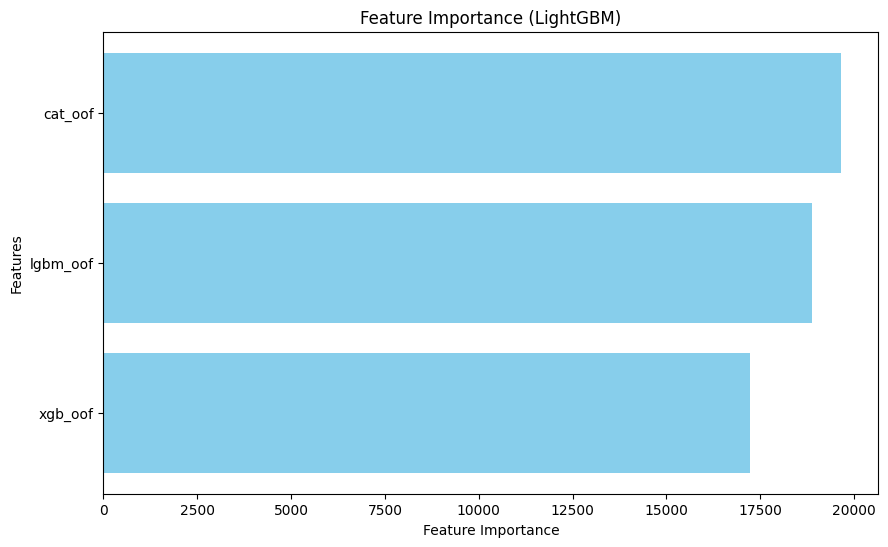

In [52]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------



best_params = lgbm_study.best_params
best_params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
    })


# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(train_meta_df, y_df)

# 예측
y_pred = final_lgbm_model.predict(test_meta_df)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': train_meta_df.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
stacking_sub2 = sub.copy()
stacking_sub2['Price'] = y_pred
stacking_sub2.to_csv('stacking_sub2.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(앙상블 시도 2)<br>
릿지를 메타모델로
</div>

In [ ]:
from sklearn.linear_model import Ridge

# Ridge 메타 모델 학습
meta_model = Ridge(alpha=1.0)  
meta_model.fit(train_meta_df, y_df)

# 최종 예측 수행
final_preds = meta_model.predict(test_meta_df)

In [49]:
# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
ridge_sub1 = sub.copy()
ridge_sub1['Price'] = final_preds
ridge_sub1.to_csv('ridge_sub1.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(앙상블 시도 3))<br>
릿지 알파 값을 다르게 해서 시도
</div>

In [53]:
# Ridge 메타 모델 학습
meta_model = Ridge(alpha= 5)  
meta_model.fit(train_meta_df, y_df)

# 최종 예측 수행
final_preds = meta_model.predict(test_meta_df)

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
ridge_sub2 = sub.copy()
ridge_sub2['Price'] = final_preds
ridge_sub2.to_csv('ridge_sub2.csv', index=False)